# Baseline 算法

动物分类教程

使用 Python 进行编程文档请参阅 https://docs.python.org/zh-cn/3/contents.html 。

使用 PyTorch 框架，下载、文档等详情参阅 https://pytorch.org/ ，具体中文文档参阅 https://www.pytorch.wiki/ 。

## 环境配置

在运行本代码前，你需要在以下选项二选一完成：本地环境配置或使用 Google Colab * <a href="https://colab.research.google.com/drive/1Lf0Y5-3gvjKKggQTf1zWrEqHYYIVp3z2#scrollTo=Omm0IoVSJ4Kw" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
完成。若你使用 Colab 可以忽略以下配置环境的过程，可直接阅读下一节。

建议你下载 Anaconda 完成虚拟环境的配置，https://www.anaconda.com ，因为在不同的项目中需要的 Python 版本、不同包的版本可能不同，因此需要不同包的管理软件。Anaconda 的使用，参阅 https://anaconda.cloud/support-center ，或 https://zhuanlan.zhihu.com/p/348120084 获得对新手更为友好的中文教程。

Colab 使用建议：你可以使用你的 Google Drive，将数据集上传至 Google Drive 后，进行挂载使用。否则需要每次会话时重复上传。Google Drive 挂载在 Colab 使用参阅 https://blog.csdn.net/aiynmimi/article/details/88238246

## 数据读入

如何读入数据？参阅 https://pytorch.org/tutorials/beginner/basics/data_tutorial.html ，我们进行对数据集的读入。
在真正读入前，我们先进行一些预处理。

In [1]:
NUM_CLASSES = 22
LABELS = [
    "ape", "bear", "bison", "cat", 
    "chicken", "cow", "deer", "dog",
    "dolphin", "duck", "eagle", "fish", 
    "horse", "lion", "lobster", "pig", 
    "rabbit", "shark", "snake", "spider", 
    "turkey", "wolf"
]
LABEL_MAP = {
    0: "ape", 1: "bear", 2: "bison", 3: "cat", 
    4: "chicken", 5: "cow", 6: "deer", 7: "dog",
    8: "dolphin", 9: "duck", 10: "eagle", 11: "fish", 
    12: "horse", 13: "lion", 14: "lobster", 
    15: "pig", 16: "rabbit", 17: "shark", 18: "snake", 
    19: "spider", 20:  "turkey", 21: "wolf"
}

你还需要把训练集进行分割，分割出 Valid 集

由于本任务数据的特殊性，可以直接使用 ImageFolder ，而不需要单独设计 Dataset 类，因此先定义 transformss, 参阅 https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html 。

In [2]:
from torchvision import transforms
import torch
transform_labeled = transforms.Compose((transforms.ToTensor(), transforms.Resize(256), transforms.CenterCrop(224),transforms.Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])))
transform_val = transforms.Lambda(lambda y: torch.zeros(NUM_CLASSES, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

将训练、测试集读入 DataLoader

In [3]:
import os

from torchvision.datasets import ImageFolder, VisionDataset
from torch.utils.data import DataLoader, random_split

data_path = './Animals Dataset' #@param 
batch_size = 32 #@param
num_workers = 0 #@param
val_size = 150 #@param

train_path = (os.path.join(data_path, 'train'))
test_path = (os.path.join(data_path, 'test'))

train_dataset = ImageFolder(
    train_path,
    transform_labeled)
test_dataset = VisionDataset(
    test_path,
    transform_val)
train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - val_size, val_size])

随机挑选16张图片测试数据读入是否顺利

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

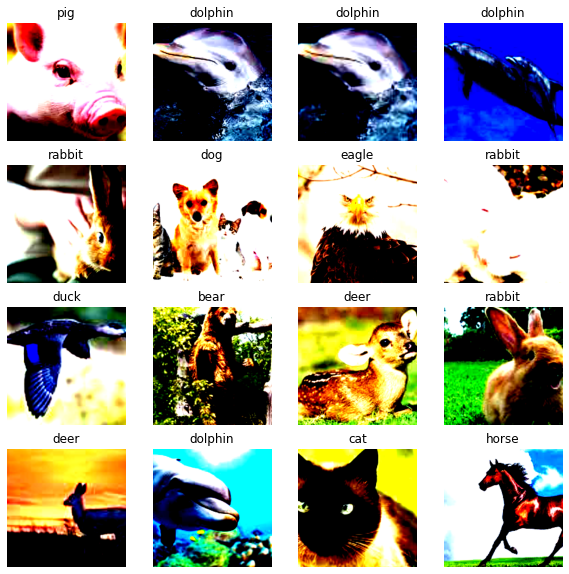

In [4]:
import matplotlib.pyplot as plt
from torch import randint
%matplotlib inline
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(LABEL_MAP[label])
    plt.axis("off")
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img.squeeze())
plt.show()

## 建立模型

本节介绍如何定义一个模型，参阅 https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 

先进行预处理

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=val_size,
    num_workers=num_workers,
    shuffle=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers)

Using cuda device


定义模型类，注意到 PyTorch 是动态图，因此在数据进行前向传播时我们相当于已经定义了 Backpropagation 反向传播。

In [6]:
'''
class BersonNetwork(nn.Module):
  def __init__(self):
    super(BersonNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.c1 = nn.Conv2d(3, 20, 5, 2, 0)
    self.c2 = nn.Conv2d(20, 1, 5, 1, 0)
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(3364, 128),
        nn.ReLU(),
        nn.Linear(128, 512),
        nn.ReLU(),
        nn.Linear(512, 22),
    )

  def forward(self, x):
    x = self.c1(x)
    x = F.relu(x) #!Question: What's the difference between torch.nn.relu() and torch.nn.F.relu()
    x = self.c2(x)
    x = F.relu(x)
    x = x.view(x.size(0), -1)
    logits = self.linear_relu_stack(x)
    return logits
    '''

"\nclass BersonNetwork(nn.Module):\n  def __init__(self):\n    super(BersonNetwork, self).__init__()\n    self.flatten = nn.Flatten()\n    self.c1 = nn.Conv2d(3, 20, 5, 2, 0)\n    self.c2 = nn.Conv2d(20, 1, 5, 1, 0)\n    self.linear_relu_stack = nn.Sequential(\n        nn.Linear(3364, 128),\n        nn.ReLU(),\n        nn.Linear(128, 512),\n        nn.ReLU(),\n        nn.Linear(512, 22),\n    )\n\n  def forward(self, x):\n    x = self.c1(x)\n    x = F.relu(x) #!Question: What's the difference between torch.nn.relu() and torch.nn.F.relu()\n    x = self.c2(x)\n    x = F.relu(x)\n    x = x.view(x.size(0), -1)\n    logits = self.linear_relu_stack(x)\n    return logits\n    "

这样模型就可以定义为：

In [7]:
'''
model = BersonNetwork().to(device)
print(model)
model.train()
'''

'\nmodel = BersonNetwork().to(device)\nprint(model)\nmodel.train()\n'

In [8]:
from torchvision import models
model = models.resnet34().to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

设置模型训练超参数、损失函数与优化器

In [9]:
learning_rate = 1e-3  # @param
# batch_size = 32 #@param 此处貌似在DataLoader部分定义了
epochs = 100  # @param
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, cooldown=5, min_lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)


定义评价指标

In [10]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self, name, fmt=':f'):
      self.name = name
      self.fmt = fmt
      self.reset()

  def reset(self):
      self.val = 0
      self.avg = 0
      self.sum = 0
      self.count = 0

  def update(self, val, n=1):
      self.val = val
      self.sum += val * n
      self.count += n
      self.avg = self.sum / self.count

  def __str__(self):
      fmtstr = '{name} {avg' + self.fmt + '}'
      return fmtstr.format(**self.__dict__)

def accuracy(output, target, topk=(1,)):
  """Computes the accuracy over the k top predictions for the specified values of k"""
  with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
losses = AverageMeter('Loss', ':.4e')
top1 = AverageMeter('Acc@1', ':6.2f')
top5 = AverageMeter('Acc@5', ':6.2f')

训练

In [11]:
import time

loss_history = []
top1_history = []
top5_history = []
best_loss = 0x7fffffff

start = time.time()
for i in range(epochs):
  for batch, (X, y) in enumerate(train_loader):
    X = X.to(device)
    y = y.to(device)
    data_time.update(time.time() - start)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  batch_time.update(time.time() - start)
  start = time.time()

  scheduler.step()

  with torch.no_grad():
    for batch, (X, y) in enumerate(val_loader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      loss = loss_fn(pred, y)
      if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = i
        best_model = model
      acc1, acc5 = accuracy(pred, y, topk=(1, 5))
      loss_history.append(loss.item())
      top1_history.append(acc1[0])
      top5_history.append(acc5[0])
      losses.update(loss.item(), X.size(0))
      top1.update(acc1[0], X.size(0))
      top5.update(acc5[0], X.size(0))
      
  print(f"Epoch:{i + 1}: {batch_time}, {losses}, {top1}, {top5}")
  losses.reset()
  top1.reset()
  top5.reset()

print(f"Best Epoch:{best_epoch + 1}, loss: {loss_history[best_epoch]}, Acc@1: {top1_history[best_epoch]}, Acc@5: {top5_history[best_epoch]}")
    


Epoch:1: Time 12.726, Loss 2.7762e+00, Acc@1  20.00, Acc@5  51.33
Epoch:2: Time 13.173, Loss 2.7174e+00, Acc@1  20.67, Acc@5  55.67
Epoch:3: Time 13.341, Loss 2.6304e+00, Acc@1  22.00, Acc@5  58.00
Epoch:4: Time 13.438, Loss 2.5781e+00, Acc@1  22.17, Acc@5  60.17
Epoch:5: Time 13.483, Loss 2.5494e+00, Acc@1  23.47, Acc@5  60.53
Epoch:6: Time 13.520, Loss 2.4970e+00, Acc@1  25.00, Acc@5  62.22
Epoch:7: Time 13.540, Loss 2.4790e+00, Acc@1  25.81, Acc@5  63.33
Epoch:8: Time 13.553, Loss 2.4451e+00, Acc@1  26.92, Acc@5  64.17
Epoch:9: Time 13.576, Loss 2.4194e+00, Acc@1  28.00, Acc@5  65.41
Epoch:10: Time 13.579, Loss 2.3822e+00, Acc@1  29.00, Acc@5  66.80
Epoch:11: Time 13.609, Loss 2.3579e+00, Acc@1  30.12, Acc@5  67.39
Epoch:12: Time 13.639, Loss 2.3286e+00, Acc@1  30.78, Acc@5  68.28
Epoch:13: Time 13.661, Loss 2.3013e+00, Acc@1  31.54, Acc@5  69.03
Epoch:14: Time 13.680, Loss 2.2762e+00, Acc@1  31.90, Acc@5  69.86
Epoch:15: Time 13.701, Loss 2.2647e+00, Acc@1  32.36, Acc@5  70.27
Epoc

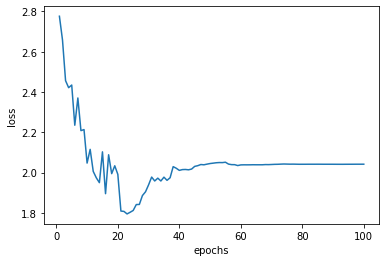

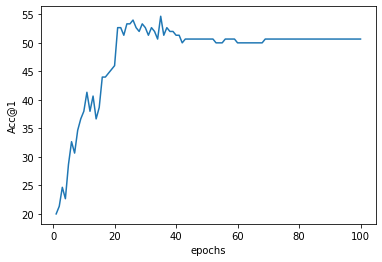

<Figure size 432x288 with 0 Axes>

In [12]:
import numpy as np
plt.plot(np.arange(1, epochs+1), loss_history)
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.savefig("loss.png")
plt.show()
plt.clf()
plt.plot(np.arange(1, epochs+1), [i.item() for i in top1_history])
plt.xlabel("epochs")
plt.ylabel("Acc@1")
#plt.savefig("Acc.png")
plt.show()
plt.clf()

由于模型过于简单，因此训练准确率不高。你可以尝试训练其它的模型（甚至于预训练模型，但预训练模型如何进行训练也是一个值得讨论的问题）。
同时，这里并没有使用 Valid 集来进行评价，而是使用了 train 集，你可以尝试加入 Valid 集（如提前分割，或用其他方式等）



# 输出结果

输出结果非常简单，与训练类似，但模型不能更新参数

In [13]:
'''
model.eval()
labels = []
with torch.no_grad():
  for _, (images, _) in enumerate(test_loader):
    y = model(images)
    batch_labels = torch.argmax(y, dim=1)
    labels.append(batch_labels)
ans = torch.cat(labels, 0).cpu().numpy()
print(ans)
print([LABEL_MAP[i] for i in ans])
'''

'\nmodel.eval()\nlabels = []\nwith torch.no_grad():\n  for _, (images, _) in enumerate(test_loader):\n    y = model(images)\n    batch_labels = torch.argmax(y, dim=1)\n    labels.append(batch_labels)\nans = torch.cat(labels, 0).cpu().numpy()\nprint(ans)\nprint([LABEL_MAP[i] for i in ans])\n'

# 保存模型

参阅 https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [26]:
#网络_日期_时间.pt
torch.save(best_model, './ResNet34_8.30_1700.pt')

In [15]:
#model = torch.load('model.path')